In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
import dgl

Running on the GPU


Using backend: pytorch


In [2]:
prefix = '../datasets/doubleInvertedPendulum'
statesDoubleInverted = np.load(prefix + 'Dataset/states_array.npy')[:1000]
prefix = '../datasets/invertedPendulum'
statesSingleInverted = np.load(prefix + 'Dataset/states_array.npy')[:1000]
print(statesDoubleInverted.shape)
print(statesSingleInverted.shape)

(1000, 9)
(1000, 5)


In [3]:
u, v = torch.tensor([0, 1]).to(device), torch.tensor([1, 0]).to(device)
g = dgl.graph((u,v))

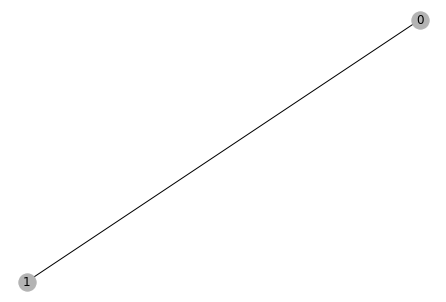

In [4]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_g = g.cpu().to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [5]:
def update_states_in_graph(state, graph):
    
    if len(state.shape) == 1:
        state = state[np.newaxis, ...]
    
    firstNode = state[:, 0:6][np.newaxis, ...]
    secondNode = np.concatenate((state[:, 0:3], state[:, 6:]), -1)[np.newaxis, ...]
    nodeData = torch.tensor(np.concatenate((firstNode, secondNode), 0), dtype=torch.float32).to(device)
    graph.ndata['state'] = nodeData

In [23]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)
            
        return x

In [36]:
messageNetwork = Network(6, 10, [16, 32, 16]).to(device)
updateNetwork = Network(16, 6, [16, 32, 16]).to(device)

In [41]:
def computeMessage(edges):
    return {'m' : messageNetwork(edges.src['state'])}

def updateFunction(nodes):
    return {'state': updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}

In [48]:
g.update_all(computeMessage, dgl.function.max('m', 'm_hat'), updateFunction)

In [43]:
update_states_in_graph(statesDoubleInverted, g)

In [50]:
print(g.nodes[0].data['state'].shape)

torch.Size([1, 1000, 6])


In [ ]:
def GraphNeuralNetwork():
    def __init__(
        graph,
        messageNetwork,
        updateNetwork
    ):
        self.graph = dgl.graph()
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
    
    def messageFunction(self, edges):
        return {'m' : self.messageNetwork(edges.src['state'])}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def forward(self, state):
        self.update_states_in_graph(state)
        
        self.graph.update_all(self.sendMessage, dgl.function.max('m', 'm_hat'), updateFunction)
        
    def update_states_in_graph(self, state):
        if len(state.shape) == 1:
            state = state[np.newaxis, ...]

        firstNode = state[:, 0:6][np.newaxis, ...]
        secondNode = np.concatenate((state[:, 0:3], state[:, 6:]), -1)[np.newaxis, ...]
        nodeData = torch.tensor(np.concatenate((firstNode, secondNode), 0), dtype=torch.float32).to(device)
        self.graph.ndata['state'] = nodeData